# 生成数据集

In [1]:
#coding:utf-8
# 0、导入模块，生成模拟数据集
import numpy as np
import matplotlib.pyplot as plt
seed = 2

def generateds():
    # 基于seed产生随机数
    rdm = np.random.RandomState(seed)
    # 随机数返回300行2列的矩阵，表示300组坐标点（x0,x1）作为输入数据集
    X = rdm.randn(300,2)
    # 从X这个300行2列的矩阵中取出一行，判断如果两个坐标的平方和小于2，给Y赋值1，其余赋值0
    # 作为输入数据集的标签（正确答案）
    Y_ = [int(x0*x0 + x1*x1 < 2) for (x0,x1) in X]
    # 遍历Y中的每一个元素，1赋值'red'，其余赋值'blue'，这样可视化显示时人可以直观区分
    Y_c = [['red' if y else 'blue'] for y in Y_]
    # 对数据集X和标签Y进行shape整理，第一个元素为-1表示，随第二个参数计算得到，第二个元素表示多少列，
    # 把X整理为n行2列，把Y整理为n行1列
    X = np.vstack(X).reshape(-1,2)
    Y_ = np.vstack(Y_).reshape(-1,1)
    return X,Y_,Y_c
    
# print X
# print Y_
# print Y_c

# 前向传播

In [2]:
#coding:utf-8
import tensorflow as tf

# 1、定义神经网络的输入、参数和输出，定义前向传播过程
def get_weight(shape,regularizer):
    w = tf.Variable(tf.random_normal(shape),dtype=tf.float32)
    tf.add_to_collection('losses',tf.contrib.layers.l2_regularizer(regularizer)(w))
    return w

def get_bias(shape):
    b = tf.Variable(tf.constant(0.01,shape=shape))
    return b

def forward(x,regularizer):
    w1 = get_weight([2,11],0.01)
    b1 = get_bias([11])
    y1 = tf.nn.relu(tf.matmul(x,w1)+b1)

    w2 = get_weight([11,1],0.01)
    b2 = get_bias([1])
    y = tf.matmul(y1,w2)+b2 #输出层不过激活
    
    return y

# 反向传播

After 0 steps,loss is: 35.364403
After 2000 steps,loss is: 7.110456
After 4000 steps,loss is: 1.204714
After 6000 steps,loss is: 0.792437
After 8000 steps,loss is: 0.604783
After 10000 steps,loss is: 0.453384
After 12000 steps,loss is: 0.358106
After 14000 steps,loss is: 0.302894
After 16000 steps,loss is: 0.264649
After 18000 steps,loss is: 0.237775
After 20000 steps,loss is: 0.216932
After 22000 steps,loss is: 0.201032
After 24000 steps,loss is: 0.188872
After 26000 steps,loss is: 0.179887
After 28000 steps,loss is: 0.173242
After 30000 steps,loss is: 0.167944
After 32000 steps,loss is: 0.163487
After 34000 steps,loss is: 0.159631
After 36000 steps,loss is: 0.156119
After 38000 steps,loss is: 0.152918


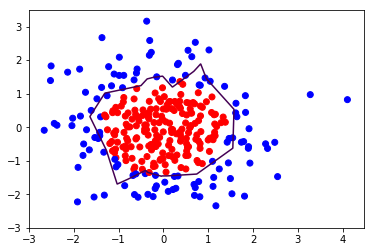

In [5]:
#coding:utf-8
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# import generateds
# import forward

STEPS = 40000
BATCH_SIZE = 30
LEARNING_RATE_BASE = 0.001
LEARNING_RATE_DECAY = 0.999
LEARNING_RATE_STEP = 1
REGULARIZER = 0.01

def backward():
    x = tf.placeholder(tf.float32,shape=(None,2))
    y_ = tf.placeholder(tf.float32,shape=(None,1))
    
    X,Y_,Y_c = generateds()
    
    y = forward(x,REGULARIZER)
    
    global_step = tf.Variable(0,trainable=False)
    
    #定义指数下降学习率
    learning_rate = tf.train.exponential_decay(
        LEARNING_RATE_BASE,
        global_step,
        LEARNING_RATE_STEP,
        LEARNING_RATE_DECAY,
        staircase=True)
    
    #定义损失函数
    loss_mse = tf.reduce_mean(tf.square(y - y_))#不含正则化
    loss_total = loss_mse + tf.add_n(tf.get_collection('losses'))#含正则化
    
    #定义反向传播方法：包含正则化
    train_step = tf.train.AdamOptimizer(0.0001).minimize(loss_total)

    with tf.Session() as sess:
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        STEPS = 40000
        for i in range(STEPS):
            start = (i * BATCH_SIZE) % 300
            end = start + BATCH_SIZE
            sess.run(train_step,feed_dict={x:X[start:end],y_:Y_[start:end]})
            if i % 2000 ==0:
                loss_v = sess.run(loss_total,feed_dict={x:X,y_:Y_})
                print "After %d steps,loss is: %f" % (i,loss_v)
            
        #xx在-3到3之间以步长为0.01，yy在-3到3之间以步长0.01，生成二维网格坐标点
        xx,yy = np.mgrid[-3:3:.01,-3:3:.01]
        #将xx yy拉直，并合并成一个2列的矩阵，得到一个网格坐标点的集合
        grid = np.c_[xx.ravel(),yy.ravel()]
        #将网格坐标点喂入神经网络，probs为输出
        probs = sess.run(y,feed_dict={x:grid})
        #probs的shape调整成xx的样子
        probs = probs.reshape(xx.shape)
    
    plt.scatter(X[:,0],X[:,1],c=np.squeeze(Y_c))
    plt.contour(xx,yy,probs,levels=[.5])
    plt.show()
    
if __name__ == '__main__':
    backward()